# EDA and Comparison on classical ML models


Other ML modles are compared on data samples with balanced or reducing dimensionality

## Sections
0. Introduction
1. Exploratory data analysis
2. Development of traditional machine learning models for licit vs ilicit classification




## Elliptic Dataset Overview


The Elliptic Dataset is a graph network of Bitcoin transactions with handcrafted features. All features are constructed using only publicly available information.

The Elliptic DataSet maps Bitcoin transactions to real entities in two categories:

- __Licit__: exchanges, wallet providers, miners, licit services, etc.
- __Ilicit__: scams, malware, terrorist, organization, ransomware, Ponzi shcemes, etc
A given transaction is licit if the entity that generated it was licit.

- **Graph** 
  - __Nodes__ : 203,769 node transactions 
  - __Edges__ : 234,355 directed edge payments flows. 
  - 2% are ilicit (Class 1), 21% are licit (Class 2)

- __Features__ 166 features in each node.
  - 94 features : local information (timestep, number of inputs/outputs, transaction fee, output volume and aggregated figures) 
    - normalized with range of numbers 
  - 72 features : aggregated features (obtained by aggregating transaction information such as maximum, minimum, standard deviation, correlation coefficients of one hop neighbor transactions).
  - visible feature : Tx id, Time_stamp

- __Temporal Information__ 
  - 49 distinct timesteps evenly spaced with an interval of 2 weeks associated with each node, when the transaction is confirmed.


- __Data Files__
  - elliptic_txs_edgelist.csv contains graph edges information;
  - elliptic_txs_classes.csv contains information about legality of transactions;
  - elliptic_txs_features.csv contains information about transaction features; 

# Loading libraries and data

In [1]:
# !pip install imblearn
# !pip install pandasql
import numpy as np
import pandas as pd
import pandasql as pds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score 
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import networkx as nx

import os

In [2]:
# Load data from Google drive  
try:
    from google.colab import drive
    drive.mount('/content/drive')
    mount_flag = True
except ModuleNotFoundError:
    mount_flag = False
    

In [3]:
# Change the path for yours 

!ls "/content/drive/My Drive/Colab Notebooks/CIS545_ Elliptic_Bitcoin Project"

ls: /content/drive/My Drive/Colab Notebooks/CIS545_ Elliptic_Bitcoin Project: No such file or directory


In [5]:
# Use your path to load google drive data or local data, but keep the names for dataframe

if mount_flag:
    classes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CIS545_ Elliptic_Bitcoin Project/elliptic_txs_classes.csv')
    features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CIS545_ Elliptic_Bitcoin Project/elliptic_txs_features.csv', header=None)
    edges = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CIS545_ Elliptic_Bitcoin Project/elliptic_txs_edgelist.csv')
else:
    classes = pd.read_csv('../elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
    features = pd.read_csv('../elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
    edges = pd.read_csv('../elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')

In [6]:
# Add features numbering and class description
features.columns = ["txId","time_step"] + ["x.{}".format(x) for x in range(1,features.shape[1]-1)]
classes["class_description"] = classes["class"].apply(lambda x : "unknown" if x == "unknown" else ("licit" if x == "2" else "illicit"))



In [7]:

# Transform edges to undirected form 
edges_undirected = pds.sqldf("SELECT txId2 as txId1, txId1 as txId2 FROM edges UNION SELECT * FROM edges", globals())
edges_undirected = pds.sqldf("SELECT * FROM edges_undirected LEFT JOIN features ON txId2=txId", globals())

# create neighbour features with mean values
neighbour_means = edges_undirected.groupby("txId1")[["x.{}".format(x) for x in range(1,166)]].mean().reset_index()
neighbour_means.columns = ["txId"] + ["x.neighbour.mean.{}".format(x) for x in range(1,166)]

# Create dataset for further analysis by combining neighbour features with given features
df = features.merge(neighbour_means, on="txId").merge(classes, on="txId")

# Generate only "Labeled" dataset for learning
labeled = df.loc[df["class"] != "unknown"]
unlabeled = df.loc[df["class"] == "unknown"]




In [8]:
# [COMMENT] if you want to use original features, use these _own datasets.

df_own = features.merge(classes, on="txId")
labeled_own = df_own.loc[df["class"] != "unknown"]
unlabeled_own = df_own.loc[df["class"] == "unknown"]

# Exploratory Data Analysis

### Classes dataset  
We can see tha the dataset is quite imbalanced, with around 200k transactions but only about 25% of them are labeled, and of the 25% only around 2% of them are ilicit. The class imbalance may cause problems in the training of models later.

* 4545: illicit, 42019 : licit, and 157205 : unknown. (no null value)




In [ ]:
classes[['txId','class_description']].groupby('class_description').count()

,txId
class_description,
illicit,4545
licit,42019
unknown,157205


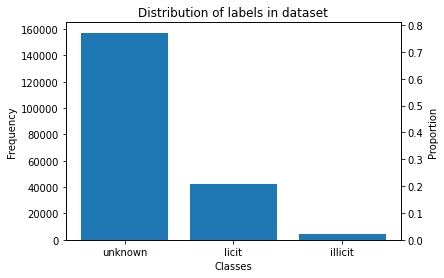

In [ ]:
fig, ax = plt.subplots()
ax.bar(classes["class_description"].unique(), classes["class_description"].value_counts())
ax.set_ylabel("Frequency")
ax.set_xlabel("Classes")
ax.set_title("Distribution of labels in dataset")
ax2 = ax.twinx()
ax2.bar(classes["class_description"].unique(), classes["class_description"].value_counts() / classes.shape[0])
ax2.set_ylabel("Proportion")
plt.show()


### Transaction Feature dataset


We can see that there are 167 columns in the dataset with 165 of them being of float type whilst the remaining 2 integer types are the transaction ID and time step. 

However we are not given much meta data on what these features are or how they were collected.

  - 94 features are data collected around local information (timestep, number of inputs/outputs, transaction fee, output volume and aggregated figures). 72 features are obtained by aggregating transaction information such as maximum, minimum, standard deviation, correlation coefficients of one hop neighbor transactions.
  - Only visible features are Tx id and Time_stamp
  - __[NEED] Explanation for neighbour_means__ : rationale
  
   we can compare the original data vs. 166+ additional neighbour_means features data?



In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Columns: 167 entries, txId to x.165
dtypes: float64(165), int64(2)
memory usage: 259.6 MB


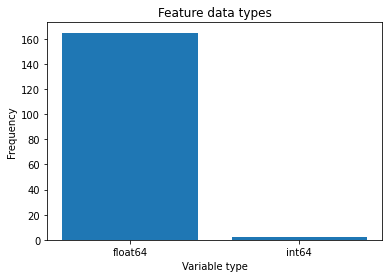

In [ ]:
plt.bar([str(x) for x in features.dtypes.value_counts().index], features.dtypes.value_counts())
plt.ylabel("Frequency")
plt.xlabel("Variable type")
plt.title("Feature data types")
plt.show()

### Edgelist dataset for graph 

*  txId1 : from node
*  txId2 : to node

In [ ]:
edges.head(3)

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870


In [ ]:
print('Total Num of Tx_nodes have out-going branch :',len(edges['txId1'].unique()))
print('Total Num of Tx_nodes have in-going branch :',len(edges['txId2'].unique()))

Total Num of Tx_nodes have out-going branch : 166345
Total Num of Tx_nodes have in-going branch : 148447


__[COMMENT]  Here we have comparisons of 'labeled' vs. 'unlabeled' dataset, but think comparison in 'labeled' dataset between 'illicit' vs. 'licit' wiil be meaningful for our goal. I modified dataset for only labeled to show pattern of illicit vs. licit and add comparison__ 

Due to large number of features, and also no contextual information given for each feature, a histogram is used instead of heatmap to visualise redundancy amongst the features. It appears most of the features are not strongly correlated to each other. However does not account for non-linear relationship.

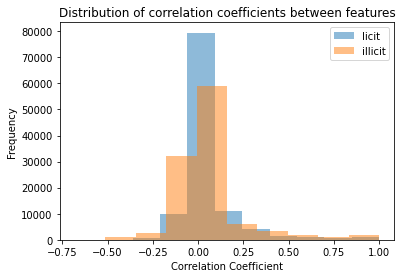

In [ ]:
plt.hist(labeled[(labeled['class_description']=='licit')].iloc[:,2:-2].corr().to_numpy().flatten(), label="licit", alpha=0.5)
plt.hist(labeled[(labeled['class_description']=='illicit')].iloc[:,2:-2].corr().to_numpy().flatten(), label="illicit", alpha=0.5)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Frequency")
plt.title("Distribution of correlation coefficients between features")
plt.legend()
plt.show()

To visualise the range of data we plot distributions of the min, max, mean, and median. It appears that the features vary in scale but have been centered already, or by for some reason the features collected are all centered around 0.

In [ ]:
# plt.hist(labeled.iloc[:,2:-2].apply(np.min), label="labeled", alpha=0.5)
# plt.hist(unlabeled.iloc[:,2:-2].apply(np.min), label="unlabeled", alpha=0.5)
# plt.xlabel("Feature value")
# plt.ylabel("Frequency")
# plt.title("Distribution of min feature values")
# plt.legend()
# plt.show()

# plt.hist(labeled.iloc[:,2:-2].apply(np.max), label="labeled", alpha=0.5)
# plt.hist(unlabeled.iloc[:,2:-2].apply(np.max), label="unlabeled", alpha=0.5)
# plt.xlabel("Feature value")
# plt.ylabel("Frequency")
# plt.title("Distribution of max feature values")
# plt.legend()
# plt.show()

# plt.hist(labeled.iloc[:,2:-2].apply(np.mean), label="labeled", alpha=0.5)
# plt.hist(unlabeled.iloc[:,2:-2].apply(np.mean), label="unlabeled", alpha=0.5)
# plt.xlabel("Feature value")
# plt.ylabel("Frequency")
# plt.title("Distribution of mean feature values")
# plt.legend()
# plt.show()

# plt.hist(labeled.iloc[:,2:-2].apply(np.median), label="labeled", alpha=0.5)
# plt.hist(unlabeled.iloc[:,2:-2].apply(np.median), label="unlabeled", alpha=0.5)
# plt.xlabel("Feature value")
# plt.ylabel("Frequency")
# plt.title("Distribution of median feature values")
# plt.legend()
# plt.show()

# plt.hist(labeled.iloc[:,2:-2].apply(np.std), label="labeled", alpha=0.5)
# plt.hist(unlabeled.iloc[:,2:-2].apply(np.std), label="unlabeled", alpha=0.5)
# plt.xlabel("Feature value")
# plt.ylabel("Frequency")
# plt.title("Distribution of std of feature values")
# plt.legend()
# plt.show()

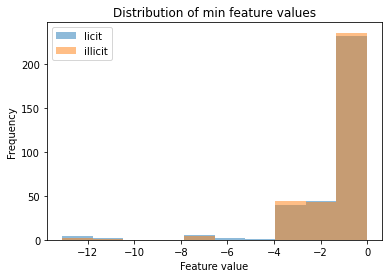

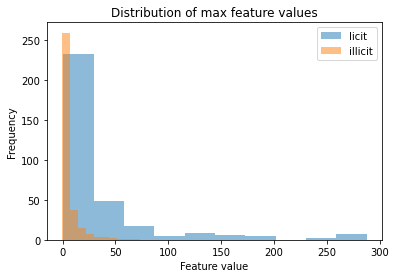

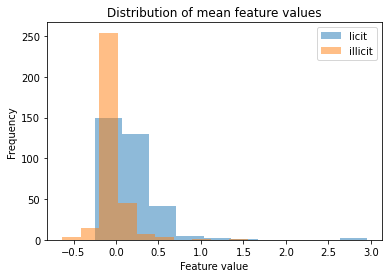

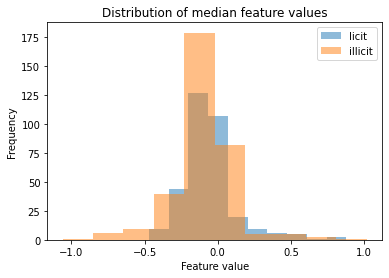

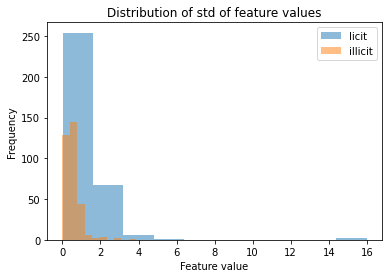

In [ ]:

plt.hist(labeled[(labeled['class_description']=='licit')].iloc[:,2:-2].apply(np.min), label="licit", alpha=0.5)
plt.hist(labeled[(labeled['class_description']=='illicit')].iloc[:,2:-2].apply(np.min), label="illicit", alpha=0.5)
plt.xlabel("Feature value")
plt.ylabel("Frequency")
plt.title("Distribution of min feature values")
plt.legend()
plt.show()

plt.hist(labeled[(labeled['class_description']=='licit')].iloc[:,2:-2].apply(np.max), label="licit", alpha=0.5)
plt.hist(labeled[(labeled['class_description']=='illicit')].iloc[:,2:-2].apply(np.max), label="illicit", alpha=0.5)
plt.xlabel("Feature value")
plt.ylabel("Frequency")
plt.title("Distribution of max feature values")
plt.legend()
plt.show()

plt.hist(labeled[(labeled['class_description']=='licit')].iloc[:,2:-2].apply(np.mean), label="licit", alpha=0.5)
plt.hist(labeled[(labeled['class_description']=='illicit')].iloc[:,2:-2].apply(np.mean), label="illicit", alpha=0.5)
plt.xlabel("Feature value")
plt.ylabel("Frequency")
plt.title("Distribution of mean feature values")
plt.legend()
plt.show()

plt.hist(labeled[(labeled['class_description']=='licit')].iloc[:,2:-2].apply(np.median), label="licit", alpha=0.5)
plt.hist(labeled[(labeled['class_description']=='illicit')].iloc[:,2:-2].apply(np.median), label="illicit", alpha=0.5)
plt.xlabel("Feature value")
plt.ylabel("Frequency")
plt.title("Distribution of median feature values")
plt.legend()
plt.show()

plt.hist(labeled[(labeled['class_description']=='licit')].iloc[:,2:-2].apply(np.std), label="licit", alpha=0.5)
plt.hist(labeled[(labeled['class_description']=='illicit')].iloc[:,2:-2].apply(np.std), label="illicit", alpha=0.5)
plt.xlabel("Feature value")
plt.ylabel("Frequency")
plt.title("Distribution of std of feature values")
plt.legend()
plt.show()

### Visualize the trends of transactions over time_stamp 

There are 49 time steps which are periods of 2 weeks of transactions.


- Labeled vs. unlabeled 
- illicit vs licit in labeled data 
- Ratio of illicit vs licit in labeled data
- Examples of distribution of feature values 

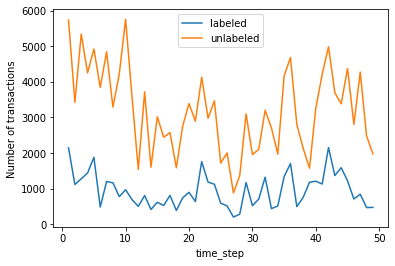

In [ ]:
labeled.groupby("time_step")["txId"].count().plot(label="labeled")
unlabeled.groupby("time_step")["txId"].count().plot(label="unlabeled")
plt.ylabel("Number of transactions")
plt.legend()
plt.show()

In [ ]:
# Fuction to draw ratio_graph over time_stamps between illicit vs. licit 

def ratio_graph(df):

  fig, ax = plt.subplots(2, 1, figsize=(10, 10))
  plt.subplots_adjust(hspace=0.4)

  
  temp_class = pd.crosstab(index=df['time_step'],columns=df['class_description'])
  temp_class.plot(kind='bar', stacked=True, ax=ax[0],\
                      title='Number of transactions per time interval', ylabel='Number of txs')
  
  
  temp_class_div = temp_class.div(temp_class.sum(1).astype(float),axis=0) 
  temp_class_div.plot(kind='bar', stacked=True,ax=ax[1], \
                      title='Percentage of transactions per time interval',ylabel='Pct of txs')

  # decrease number of ticks per x axis
  for i in range(len(ax)):
    for index, label in enumerate(ax[i].get_xticklabels()):
        if index % 4 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)

  

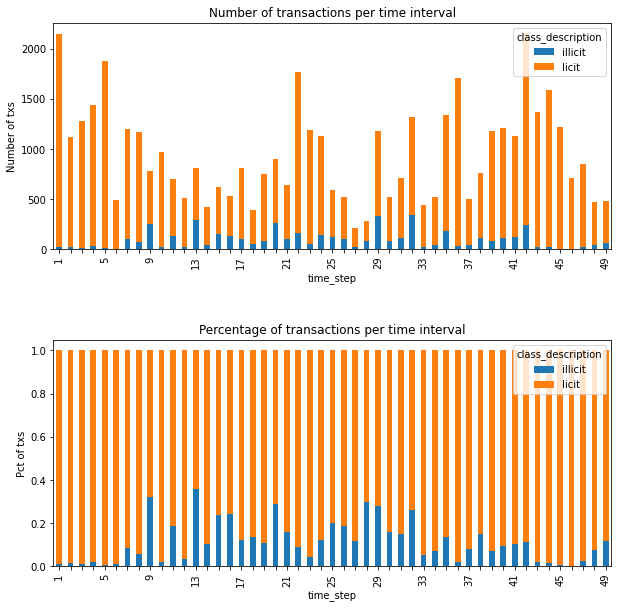

In [ ]:
ratio_graph(labeled)


__[COMMENT] just example of data distributions but we can decide to remove or to leave later__

We select few features and visualize their distributions of illicit and licit data over time

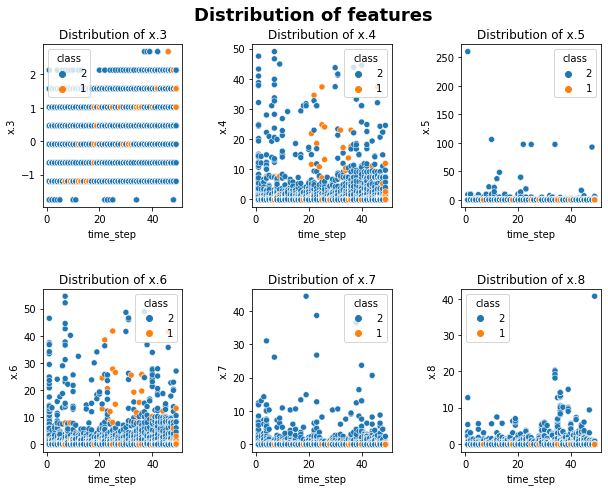

In [ ]:
# Representative distribution of features.

b=20
columns=labeled.columns
fig, axes = plt.subplots(2, 3, figsize=(10, 7.5))
plt.subplots_adjust(wspace = 0.5, hspace=0.5)
plt.suptitle("Distribution of features",y=0.95, size=18, weight='bold')


ax = sns.scatterplot(ax = axes[0,0], data=labeled, y=columns[4],x='time_step',hue='class')
ax.set_title(f'Distribution of {columns[4]}')

ax1 = sns.scatterplot(ax = axes[0,1], data=labeled, y=columns[5],x='time_step',hue='class')
ax1.set_title(f'Distribution of {columns[5]}')

ax2 = sns.scatterplot(ax = axes[0,2], data=labeled, y=columns[6],x='time_step',hue='class')
ax2.set_title(f'Distribution of {columns[6]}')

ax3 = sns.scatterplot(ax = axes[1,0], data=labeled, y=columns[7],x='time_step',hue='class')
ax3.set_title(f'Distribution of {columns[7]}')

ax4 = sns.scatterplot(ax = axes[1,1], data=labeled, y=columns[8],x='time_step',hue='class')
ax4.set_title(f'Distribution of {columns[8]}')

ax5 = sns.scatterplot(ax = axes[1,2], data=labeled, y=columns[9],x='time_step',hue='class')
ax5.set_title(f'Distribution of {columns[9]}')

 

plt.show()

### Example of Graph visualization using networkx

Elliptic dataset had graph data format for analyzing by Graph Convolutional Network. 
Here, we only visualize illicit transaction node from one time_stamp. 

In [9]:
sample_ids = labeled.loc[(labeled['time_step'] ==18)  & (labeled['class']=='1'), 'txId']
short_edges = edges.loc[edges['txId1'].isin(sample_ids)]

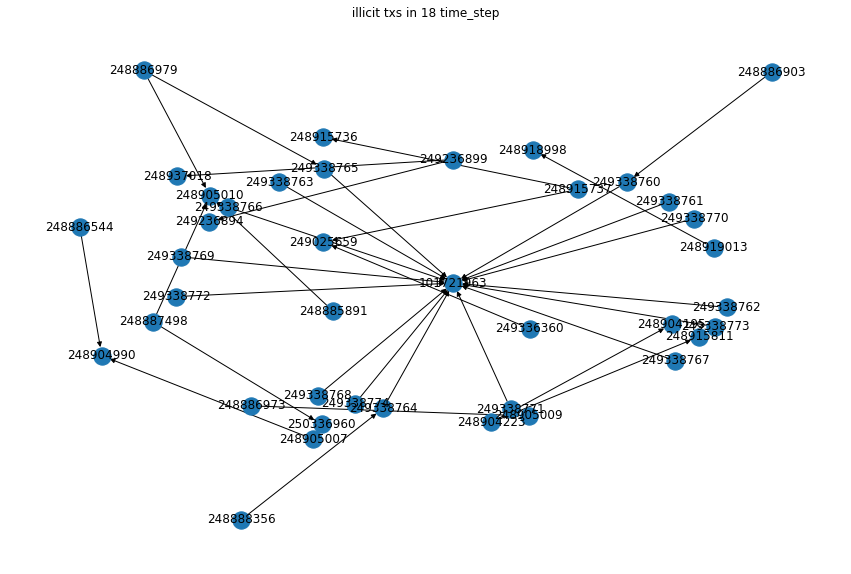

In [10]:
import networkx as nx
fig, axe = plt.subplots(figsize=(15,10))
axe.set_title(' illicit txs in 18 time_step ')

graph = nx.from_pandas_edgelist(short_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph,ax=axe, cmap = plt.get_cmap('rainbow'), with_labels=True, pos=pos )


# Resampling data 


Data is highly unbalanced. There are 42019 samples labeled as 'licit' and 4545 samples labeled as 'illicit.' Hence, we shall resample the data to balance numbers of positive and negative samples.

- Undersampling

- Oversampling 


__[COMMENT] For X_train, y_train, Please see named differently for each sampling.and only full version, not original feature (labeled_own)__ 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(labeled.iloc[:,2:-2], labeled["class"].apply(int), test_size=0.2, random_state=42)

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)


print(X_rus.shape)
print(X_ros.shape)


(7292, 330)
(67210, 330)


# Development of traditional machine learning models 

## PCA 


### Visualising transactions 'licit' vs. 'illicit' with dimensionality reduction

 - Separation of licit and ilicit 
 - Proportion of variance
 - Accumulated variance


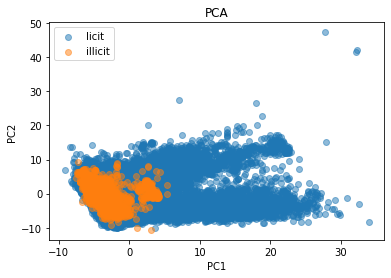

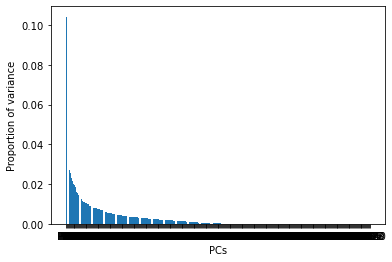

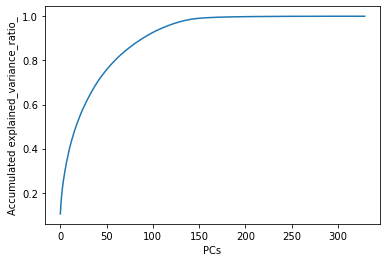

The total varience 0.9516338987258217
The number of components: 114


In [40]:
pca = PCA()
ss = StandardScaler()
ss.fit(labeled.iloc[:,2:-2])
pca_features = pca.fit_transform(ss.transform(labeled.iloc[:,2:-2]))
plt.scatter(pca_features[labeled["class"]=="2"][:,0], pca_features[labeled["class"]=="2"][:,1], alpha=0.5, label="licit")
plt.scatter(pca_features[labeled["class"]=="1"][:,0], pca_features[labeled["class"]=="1"][:,1], alpha=0.5, label="illicit")
plt.title("PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


plt.bar(["PC{}".format(x) for x in range(1, pca_features.shape[1]+1)],pca.explained_variance_ratio_)
plt.ylabel("Proportion of variance")
plt.xlabel("PCs")
plt.show()

plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PCs')
plt.ylabel('Accumulated explained_variance_ratio_')
plt.show()



var_cum = 0  # total varience from all components
num_comp = 0        # the number of components with 95% varience
for var in pca.explained_variance_ratio_:
    if var_cum > 0.95:
        print('The total varience', var_cum)
        print('The number of components:', num_comp)
        break
    else:
        var_cum += var
        num_comp += 1


Define the funcion for plotting confusion matrix

In [12]:
import itertools

class_names = ['illicit', 'licit']
def plot_confusion_matrix(cm, class_names, title=None):
    plt.figure()
    
    plt.title(title)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # plt.tight_layout()
    plt.show()


 __[COMMENT] Try with Oversampling for Logitic R, and Undersampling for SVC and RandomForest Classifiers with grid_search__

## Logistic Regression

/Users/sd/miniforge3/envs/work/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Logistic Regression Model Evaluation: 
Final Train Accuracy: 94.3305
 Final F1 Score: 94.2088


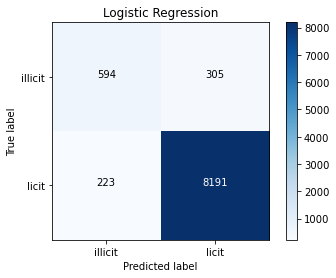

In [41]:
#Classification Stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import classification_report

#Logistic/Linear Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#  oversampled X_train and X_test are scaled and PCA-transformed.
X_train_sc = ss.fit_transform(X_ros)
pca = PCA(n_components=114).fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)

X_test_sc = ss.transform(X_test)
X_test_pca = pca.transform(X_test)

# Train a simple logistic regression classifier

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_pca, y_ros)
ypred = logreg.predict(X_test_pca)


logreg_cm= confusion_matrix(y_test, ypred)

print(f'Logistic Regression Model Evaluation: \n'
          f'Final Train Accuracy: {100.* accuracy_score(y_test, ypred):.4f}\n',
          f'Final F1 Score: {100.* f1_score(y_test, ypred, average="weighted"):.4f}')

plot_confusion_matrix(logreg_cm, class_names,'Logistic Regression' )

### Logistic regression on unsacaled imbalanced data

Logistic Regression Model Evaluation: 
Final Test Accuracy: 96.9505
 Final F1 Score: 96.8783


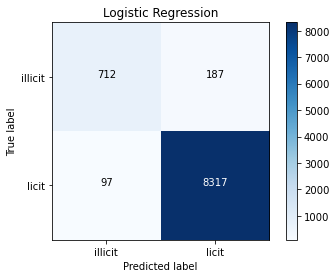

In [13]:
logreg_raw = LogisticRegression(max_iter=10000)
logreg_raw.fit(X_train, y_train)
ypred_raw = logreg_raw.predict(X_test)


logreg_raw_cm= confusion_matrix(y_test, ypred_raw)

print(f'Logistic Regression Model Evaluation: \n'
          f'Final Test Accuracy: {100.* accuracy_score(y_test, ypred_raw):.4f}\n',
          f'Final F1 Score: {100.* f1_score(y_test, ypred_raw, average="weighted"):.4f}')

plot_confusion_matrix(logreg_raw_cm, class_names,'Logistic Regression' )

## SVC

We use optimize our classifier with grid_search method for SVC and RandomForestClassification. However we utilize undersampling data for grid_search due to running time issue with oversampling data

__[COMMENT] for grid_search, we use undersampling data for SVC and RandomForestC__


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import GenericUnivariateSelect

hyper_parameters = {"Scaler" : ["passthrough", StandardScaler()],
                    "PCA" : ["passthrough", PCA(150)],
                    "Classifier__kernel" : ["poly", "rbf"],
                    "Classifier__C" : [0.1, 1, 10]
                    }

pipeline = Pipeline([("Scaler", StandardScaler()),                  
                     ("PCA", PCA()),                                
                     ("Classifier", SVC())
            ])
svc = GridSearchCV(pipeline, param_grid=hyper_parameters, verbose=2)

In [ ]:
%%time
svc.fit(X_rus, y_rus)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END Classifier__C=0.1, Classifier__kernel=poly, PCA=passthrough, Scaler=passthrough; total time=  15.4s
[CV] END Classifier__C=0.1, Classifier__kernel=poly, PCA=passthrough, Scaler=passthrough; total time=   7.9s
[CV] END Classifier__C=0.1, Classifier__kernel=poly, PCA=passthrough, Scaler=passthrough; total time=   8.3s
[CV] END Classifier__C=0.1, Classifier__kernel=poly, PCA=passthrough, Scaler=passthrough; total time=   8.7s
[CV] END Classifier__C=0.1, Classifier__kernel=poly, PCA=passthrough, Scaler=passthrough; total time=   8.9s
[CV] END Classifier__C=0.1, Classifier__kernel=poly, PCA=passthrough, Scaler=StandardScaler(); total time=   7.2s
[CV] END Classifier__C=0.1, Classifier__kernel=poly, PCA=passthrough, Scaler=StandardScaler(); total time=   5.7s
[CV] END Classifier__C=0.1, Classifier__kernel=poly, PCA=passthrough, Scaler=StandardScaler(); total time=   5.8s
[CV] END Classifier__C=0.1, Classifier__kernel=poly

GridSearchCV(estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('PCA', PCA()), ('Classifier', SVC())]),
             param_grid={'Classifier__C': [0.1, 1, 10],
                         'Classifier__kernel': ['poly', 'rbf'],
                         'PCA': ['passthrough', PCA(n_components=150)],
                         'Scaler': ['passthrough', StandardScaler()]},
             verbose=2)

In [ ]:
print("Parameters used for SVC : ", svc.best_params_)

Parameters used for SVC :  {'Classifier__C': 10, 'Classifier__kernel': 'rbf', 'PCA': 'passthrough', 'Scaler': StandardScaler()}


SVC Model Evaluation: 
Final Train Accuracy: 94.1050,
 Final F1 Score: 94.6062


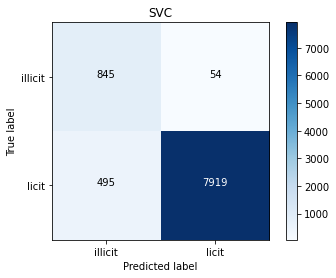

CPU times: user 5.97 s, sys: 18.3 ms, total: 5.99 s
Wall time: 5.99 s


In [ ]:
%%time

ypred = svc.best_estimator_.predict(X_test)
svc_cm= confusion_matrix(y_test, ypred)

print(f'SVC Model Evaluation: \n'
          f'Final Train Accuracy: {100.* accuracy_score(y_test, ypred):.4f},\n',
          f'Final F1 Score: {100.* f1_score(y_test, ypred, average="weighted"):.4f}')

plot_confusion_matrix(svc_cm, class_names,'SVC' )


### SVC on sacaled raw data with regularization parameter C = 15 

SVC Model Evaluation: 
Final Train Accuracy: 98.1424,
 Final F1 Score: 98.1230


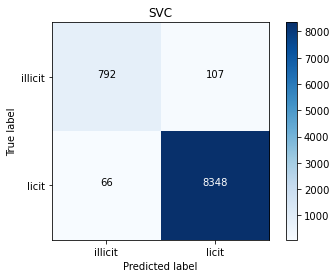

CPU times: user 1min 30s, sys: 535 ms, total: 1min 30s
Wall time: 1min 30s


In [35]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

svc_raw = make_pipeline(StandardScaler(), SVC(C = 15, gamma='auto'))
svc_raw.fit(X_train, y_train)
ypred_raw = svc_raw.predict(X_test)
svc_raw_cm= confusion_matrix(y_test, ypred_raw)

print(f'SVC Model Evaluation: \n'
          f'Final Train Accuracy: {100.* accuracy_score(y_test, ypred_raw):.4f},\n',
          f'Final F1 Score: {100.* f1_score(y_test, ypred_raw, average="weighted"):.4f}')

plot_confusion_matrix(svc_raw_cm, class_names,'SVC' )


## RandomForest

We optimize RandomForest Classification with grid_search, balanced data 

In [32]:
%%time

from sklearn.ensemble import RandomForestClassifier
hyper_parameters = {"criterion" : ["entropy", "gini"],
                    "max_features" : ["sqrt", "log2"],
                    "max_depth" : [None, 5, 10] 
                    }

clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid=hyper_parameters, verbose=2)
rfc=grid_search.fit(X_rus, y_rus)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END criterion=entropy, max_depth=None, max_features=sqrt; total time=   1.9s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt; total time=   1.9s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt; total time=   1.9s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt; total time=   1.8s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt; total time=   1.8s
[CV] END criterion=entropy, max_depth=None, max_features=log2; total time=   0.9s
[CV] END criterion=entropy, max_depth=None, max_features=log2; total time=   1.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2; total time=   1.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2; total time=   1.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2; total time=   1.0s
[CV] END ..criterion=entropy, max_depth=5, max_features=sqrt; total time=   1.2s
[CV] END ..criterion=entropy, max_dept

In [33]:
print("Parameters used for RandomForest Classifier: ", rfc.best_params_)

Parameters used for RandomForest Classifier:  {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt'}


SVC Model Evaluation: 
Final Train Accuracy: 97.9921,
 Final F1 Score: 98.0394


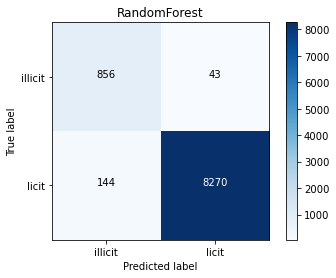

CPU times: user 207 ms, sys: 16.6 ms, total: 224 ms
Wall time: 153 ms


In [34]:
%%time

rfc = rfc.best_estimator_
ypred = rfc.predict(X_test)
rfc_cm= confusion_matrix(y_test, ypred)

print(f'SVC Model Evaluation: \n'
          f'Final Train Accuracy: {100.* accuracy_score(y_test, ypred):.4f},\n',
          f'Final F1 Score: {100.* f1_score(y_test, ypred, average="weighted"):.4f}')

plot_confusion_matrix(rfc_cm, class_names,'RandomForest' )


### Random Forest Classifier on imbalanced raw data

SVC Model Evaluation: 
Final Train Accuracy: 98.7652,
 Final F1 Score: 98.7293


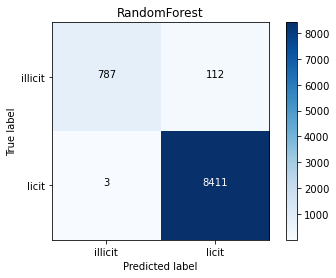

In [37]:
rfc_raw = RandomForestClassifier()
rfc_raw.fit(X_train, y_train)
ypred_raw = rfc_raw.predict(X_test)
rfc_raw_cm= confusion_matrix(y_test, ypred_raw)

print(f'SVC Model Evaluation: \n'
          f'Final Test Accuracy: {100.* accuracy_score(y_test, ypred_raw):.4f},\n',
          f'Final F1 Score: {100.* f1_score(y_test, ypred_raw, average="weighted"):.4f}')

plot_confusion_matrix(rfc_raw_cm, class_names,'RandomForest' )


## ROC Curve Comparison for LR, SVC, RF 

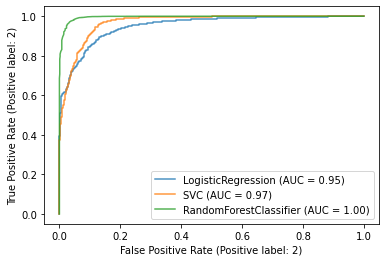

In [42]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
Log_disp = RocCurveDisplay.from_estimator(logreg, X_test_pca, y_test, ax=ax, alpha=0.8)
svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test, ax=ax, alpha=0.8)
rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

#### AdaBoostClassifier

AdaBoost Model Evaluation: 
Final Test Accuracy: 99.1839,
 Final F1 Score: 99.1748


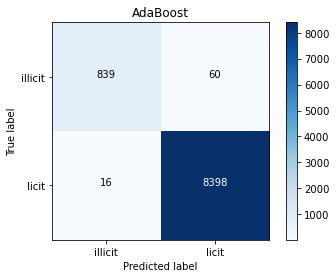

In [63]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators = 150 , random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(labeled.iloc[:,2:-2], labeled["class"].apply(int), test_size=0.2, random_state=42)

ada.fit(X_train, y_train)
ypred_ada = ada.predict(X_test)
ada_cm = confusion_matrix(y_test, ypred_ada)

print(f'AdaBoost Model Evaluation: \n'
          f'Final Test Accuracy: {100.* accuracy_score(y_test, ypred_ada):.4f},\n',
          f'Final F1 Score: {100.* f1_score(y_test, ypred_ada, average="weighted"):.4f}')

plot_confusion_matrix(ada_cm, class_names,'AdaBoost' )


#### ROC Curve Comparison for LR, SVC, RF, ABC on imbalanced data

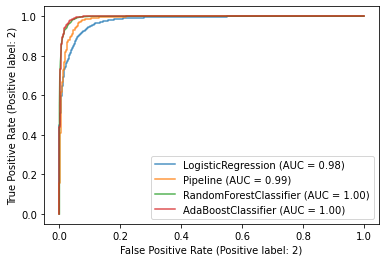

In [64]:
ax = plt.gca()
Log_disp = RocCurveDisplay.from_estimator(logreg_raw, X_test, y_test, ax=ax, alpha=0.8)
svc_disp = RocCurveDisplay.from_estimator(svc_raw, X_test, y_test, ax=ax, alpha=0.8)
rfc_disp = RocCurveDisplay.from_estimator(rfc_raw, X_test, y_test, ax=ax, alpha=0.8)
ada_disp = RocCurveDisplay.from_estimator(ada, X_test, y_test, ax=ax, alpha=0.8)

plt.show()

#### Conclusion. Resampling methods (oversampling and undersampling) are not efficient in the learning models we have investigated. 